In [1]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pickle

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

In [2]:
def read_file(path):
    df = pd.read_excel(path)
    df.columns = df.iloc[4]
    df = df.iloc[5:][df.columns[:-1]]

    columns = df.columns.tolist()

    columns[3] = 'продажи'
    columns[16] = 'заболеваемость'
    columns[33] = 'ТВ реклама, руб'
    columns[35] = 'интернет реклама, руб'
    columns[51] = 'wordstat'
    
    df.columns = columns
    df.loc[df['неделя']==53, 'неделя'] = 52

    df['реклама_сум'] = df['ТВ реклама, руб'].replace(' ', 0).astype(float) + df['интернет реклама, руб'].replace(' ', 0).astype(float)

    df['Начало нед'] = pd.to_datetime(df['Начало нед'])




    return df

df = read_file('data/train.xlsx')
df.loc[df['неделя']==53, 'неделя'] = 52

/var/folders/bb/jzxxldrn52l0stzqmszjx6840000gn/T/ipykernel_33502/4174850656.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['реклама_сум'] = df['ТВ реклама, руб'].replace(' ', 0).astype(float) + df['интернет реклама, руб'].replace(' ', 0).astype(float)


In [3]:
df['year'] = df['Начало нед'].dt.year

# df.loc[df['year'] <= 2020, 'продажи'] += 5_000_000

In [4]:
# plt.figure(figsize=(15, 8))

# plt.plot(df[df['продажи'].notna()]['продажи'])
# df.loc[df['year'] <= 2020, 'продажи'] += 5_000_000
# plt.plot(df[df['продажи'].notna()]['продажи'])

In [5]:
# df['money'] = df['Медиа ТВ (Моделироуемый бренд)_(тотал)ТВ, рубли'] + df['Медиа Диджитал (Моделируемый бренд)_Диджитал, рубли']

# plt.figure(figsize=(45, 15))

# cur_df = df[df.value.notna()]
# plt.plot(cur_df['Период_Начало нед'], cur_df['value'] / cur_df['value'].max())
# plt.plot(cur_df['Период_Начало нед'], cur_df['money'] / cur_df['money'].max())
# plt.plot(cur_df['Период_Начало нед'], cur_df['статистика заболеваемости_Статистика заболеваемости'] / cur_df['статистика заболеваемости_Статистика заболеваемости'].max())

# plt.legend(['кол-во продаж', 'кол-во рекламы', 'заболеваемость'])

In [6]:
def create_features(df):

    week_info = df.groupby('неделя')['продажи'].agg(['sum', 'count'])
    week_info.columns = [f'week_{x}' for x in week_info.columns]

    for i in range(29):
        df[f'target_{i+1}'] = df['продажи'].shift(-i) / df['продажи'].shift(1)


    df['ТВ реклама, руб'] = df['ТВ реклама, руб'].replace(' ',0).astype(float)
    df['feature_reklama_1'] = df['ТВ реклама, руб'].shift(1).rolling(window=5).mean()
    df['feature_reklama_-10'] = df['ТВ реклама, руб'].shift(-10).rolling(window=5).mean()

    # week_info_dict = week_info.to_dict()
    for i in range(29):
        df['tmp'] = df['неделя'] + i
        df = df.merge(week_info, how='left', right_index=True, left_on='tmp')
        df['week_sum'] -= df['продажи'].shift(-i)
        df['week_count'] -= 1
        df[f'feature_mean_week_{i}'] = df['week_sum'] / df['week_count']
        df[f'feature_mean_week_norm_{i}'] = df[f'feature_mean_week_{i}'] / df['продажи'].shift(1)
        df.drop(['week_sum', 'week_count'], axis=1, inplace=True)

    df['feature_illnesses'] = df['заболеваемость'].shift(1)

    df['feature_week'] = df['неделя']

    for i in range(1, 16, 4):
        df[f'feature_month_diff_{i}'] = df['продажи'].shift(i) / df['продажи'].shift(i+4)

    for i in [7, 13, 20]:
        df[f'feature_big_diff_{i}_weeks'] = df['продажи'].shift(1) / df['продажи'].shift(i)

    bad_cols = [col for col in df.columns if 'feature' not in col and 'target' not in col]
    df.drop(bad_cols, axis=1, inplace=True)
    
    return df

df = create_features(df)

/var/folders/bb/jzxxldrn52l0stzqmszjx6840000gn/T/ipykernel_33502/1326248554.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ТВ реклама, руб'] = df['ТВ реклама, руб'].replace(' ',0).astype(float)


In [7]:
df = df[df['target_1'].notna()].reset_index(drop=True)
df = df.loc[20:].reset_index(drop=True)

In [8]:
test_size = 0.2

all_models = []
all_metrics = []
all_preds = []
for i in range(1, 30):
    print(f'Предсказываение на {i} недель вперед')

    cur_df = df[df[f'target_{i}'].notna()]

    # if i <= 20:
        # cur_df = cur_df[(cur_df[f'target_1'] < 1.5) & (cur_df[f'target_1'] > 0.7)]
    cur_df = cur_df.drop([43-i, 44-i, 45-i, 46-i])

    # for j in range(1, 30):
    #     if abs(i - j) >= 7:
    #         # print(i, j)
    #         # display(cur_df)
    #         cur_df = cur_df.drop([f'feature_mean_week_{j-1}', f'feature_mean_week_norm_{j-1}'], axis=1)

    train_data, valid_data = cur_df[:int(len(cur_df) * (1-test_size))], cur_df[int(len(cur_df) * (1-test_size)):]

    X_train, y_train = train_data.drop([x for x in train_data.columns if 'target' in x], axis=1), train_data[f'target_{i}']
    X_valid, y_valid = valid_data.drop([x for x in valid_data.columns if 'target' in x], axis=1), valid_data[f'target_{i}']


    model = CatBoostRegressor(
        depth=3,
        learning_rate=0.03,
        iterations=3000,
        loss_function='MAPE',
        eval_metric='R2',
        custom_metric=['R2'],

        random_state=42,
        thread_count=5
    )

    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=1000)
    all_models.append(model)

    preds = model.predict(X_valid)
    all_preds.append(preds)

    r2_metric = metrics.r2_score(y_valid, preds)
    mape_metric = metrics.mean_absolute_percentage_error(y_valid, preds)
    all_metrics.append([r2_metric, mape_metric])

    print(f'R2: {round(r2_metric, 5)}')
    print(f'MAPE: {round(mape_metric, 5)}')
    
    print()

Предсказываение на 1 недель вперед
0:	learn: 0.0010143	test: -0.0033089	best: -0.0033089 (0)	total: 54.9ms	remaining: 2m 44s
1000:	learn: 0.6989654	test: 0.2215881	best: 0.2378175 (794)	total: 499ms	remaining: 997ms


In [ ]:
with open("models.pkl", "wb") as file:
    pickle.dump(all_models, file)

In [ ]:
pd.DataFrame({
    'name': X_train.columns,
    'imp': all_models[-1].get_feature_importance()
}).sort_values('imp', ascending=False)

,name,imp
37,feature_mean_week_norm_17,7.590840
35,feature_mean_week_norm_16,5.550337
41,feature_mean_week_norm_19,4.924634
3,feature_mean_week_norm_0,3.740357
43,feature_mean_week_norm_20,3.713961
39,feature_mean_week_norm_18,3.655551
67,feature_big_diff_13_weeks,3.552129
68,feature_big_diff_20_weeks,3.511933
59,feature_mean_week_norm_28,2.996997
66,feature_big_diff_7_weeks,2.574461


In [ ]:
print(f'R2: {round(np.mean([x[0] for x in all_metrics]), 5)}')
print(f'MAPE: {round(np.mean([x[1] for x in all_metrics]), 5)}')

R2: 0.4132
MAPE: 0.10785


R2: 0.42683
MAPE: 0.10619

In [ ]:
cur_df = df[df[f'target_29'].notna()]

preds = [all_models[i].predict(cur_df[[col for col in cur_df.columns if 'feature' in col]].iloc[[-10]])[0] for i in range(29)]

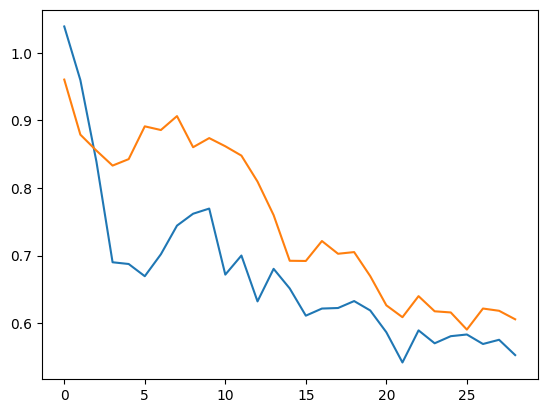

In [ ]:
plt.plot([cur_df.iloc[-10][f'target_{i}'] for i in range(1, 30)])
plt.plot(preds)

-----

In [ ]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pickle

pd.options.display.max_columns = 200

In [ ]:
all_models = pickle.load(open('models.pkl', 'rb'))

In [ ]:
def read_file(path):
    df = pd.read_excel(path)
    df.columns = df.iloc[4]
    df = df.iloc[5:][df.columns[:-1]]

    columns = df.columns.tolist()

    columns[3] = 'продажи'
    columns[16] = 'заболеваемость'
    columns[33] = 'ТВ реклама, руб'
    columns[35] = 'интернет реклама, руб'
    columns[51] = 'wordstat'
    
    df.columns = columns
    df.loc[df['неделя']==53, 'неделя'] = 52

    df['продажи']

    return df

df = read_file('data/train.xlsx')
df.loc[df['неделя']==53, 'неделя'] = 52

In [ ]:
df[df['год'].notna()]

,год,неделя,Начало нед,продажи,"Продажи, рубли","Продажи, упаковки","Продажи, рубли","Продажи, рубли","раствор 0.01 % 150 мл N1, руб","раствор 0.01 % 50 мл N1, руб","раствор 0.01 % 500 мл N1, руб","раствор 0.01 % 150 мл N1, упаковки","раствор 0.01 % 50 мл N1, упаковки","раствор 0.01 % 500 мл N1, упаковки",Дистрибуция Мирамистин,Выписки,заболеваемость,Индекс цены,Развитие Дженериков \n(средняя дистрибуция),Развитие Дженериков \n(кол-во брендов),"(1)\nТВ, trp\n(Ж 30-60 ВС)","(1)\nТВ, рубли","(1)\nТВ, охват 5+\n(Ж 30-60 ВС)","(2)\nТВ, trp\n(Ж 30-60 ВС)","(2)\nТВ, рубли","(2)\nТВ, охват 5+\n(Ж 30-60 ВС)","(3)\nТВ, trp\n(Ж 30-60 ВС)","(3)\nТВ, рубли","(3)\nТВ, охват 5+\n(Ж 30-60 ВС)","(4)\nТВ, trp\n(Ж 30-60 ВС)","(4)\nТВ, рубли","(4)\nТВ, охват 5+\n(Ж 30-60 ВС)","(тотал)\nТВ, trp\n(Ж 30-60 ВС)","ТВ реклама, руб","(тотал)\nТВ, охват 5+\n(Ж 30-60 ВС)","интернет реклама, руб","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, количество выходов",wordstat,"ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб",...,"ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли",Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого
5,2019,1,2018-12-31 00:00:00,41535567.339,0,114621.15,41535567.339,0,0,0,0,0,0,0,0.92107,99698.595433,508956,1.54132,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,0,1057612.5,0,0,0,0,0,0,0,0,0

In [ ]:
def create_features(df):

    week_info = df.groupby('неделя')['продажи'].agg(['sum', 'count'])
    week_info.columns = [f'week_{x}' for x in week_info.columns]

    # df = df.merge(week_info, how='left', right_index=True, left_on='неделя')
    # df['week_sum'] -= df['продажи']
    # df['week_count'] -= 1
    # df['feature_mean_week'] = df['week_sum'] / df['week_count']
    # df['feature_mean_week_norm'] = df['feature_mean_week'] / df['продажи'].shift(1)
    # df.drop(['week_sum', 'week_count'], axis=1, inplace=True)

    for i in range(29):
        df[f'target_{i+1}'] = df['продажи'].shift(-i) / df['продажи'].shift(1)

    # week_info_dict = week_info.to_dict()
    for i in range(29):
        df['tmp'] = df['неделя'] + i
        df = df.merge(week_info, how='left', right_index=True, left_on='tmp')
        # df['week_sum'] -= df[f'target_{i+1}']
        # df['week_count'] -= 1
        df[f'feature_mean_week_{i}'] = df['week_sum'] / df['week_count']
        df[f'feature_mean_week_norm_{i}'] = df[f'feature_mean_week_{i}'] / df['продажи'].shift(1)
        df.drop(['week_sum', 'week_count'], axis=1, inplace=True)

    df['feature_illnesses'] = df['заболеваемость'].shift(1)

    df['feature_week'] = df['неделя']

    for i in range(1, 16, 4):
        df[f'feature_month_diff_{i}'] = df['продажи'].shift(i) / df['продажи'].shift(i+4)

    for i in [7, 13, 20]:
        df[f'feature_big_diff_{i}_weeks'] = df['продажи'].shift(1) / df['продажи'].shift(i)

    # bad_cols = [col for col in df.columns if 'feature' not in col and 'target' not in col]
    # df.drop(bad_cols, axis=1, inplace=True)
    
    return df

df = create_features(df)
df = df.reset_index(drop=True)

In [ ]:
max_id = df[df['target_1'].notna()].index.max()

max_id

243

In [ ]:
preds = [df.iloc[max_id]['продажи'] * model.predict(df[all_models[0].feature_names_].iloc[max_id+1]) for model in all_models]

sample = pd.DataFrame({
    'week': ['04.09.2023', '11.09.2023', '18.09.2023', '25.09.2023', '02.10.2023', '09.10.2023', '16.10.2023', '23.10.2023', '30.10.2023', '06.11.2023', '13.11.2023', '20.11.2023', '27.11.2023', '04.12.2023', '11.12.2023', '18.12.2023', '25.12.2023', '01.01.2024', '08.01.2024', '15.01.2024', '22.01.2024', '29.01.2024', '05.02.2024', '12.02.2024', '19.02.2024', '26.02.2024', '04.03.2024', '11.03.2024', '18.03.2024'],
    'revenue': preds
})

sample

,week,revenue
0,04.09.2023,6.647423e+07
1,11.09.2023,7.524012e+07
2,18.09.2023,7.334702e+07
3,25.09.2023,7.901507e+07
4,02.10.2023,7.746208e+07
5,09.10.2023,7.624466e+07
6,16.10.2023,7.622572e+07
7,23.10.2023,7.523091e+07
8,30.10.2023,7.465464e+07
9,06.11.2023,7.321655e+07


In [ ]:
prev = df[df['продажи'].notna()]['продажи'].tolist()

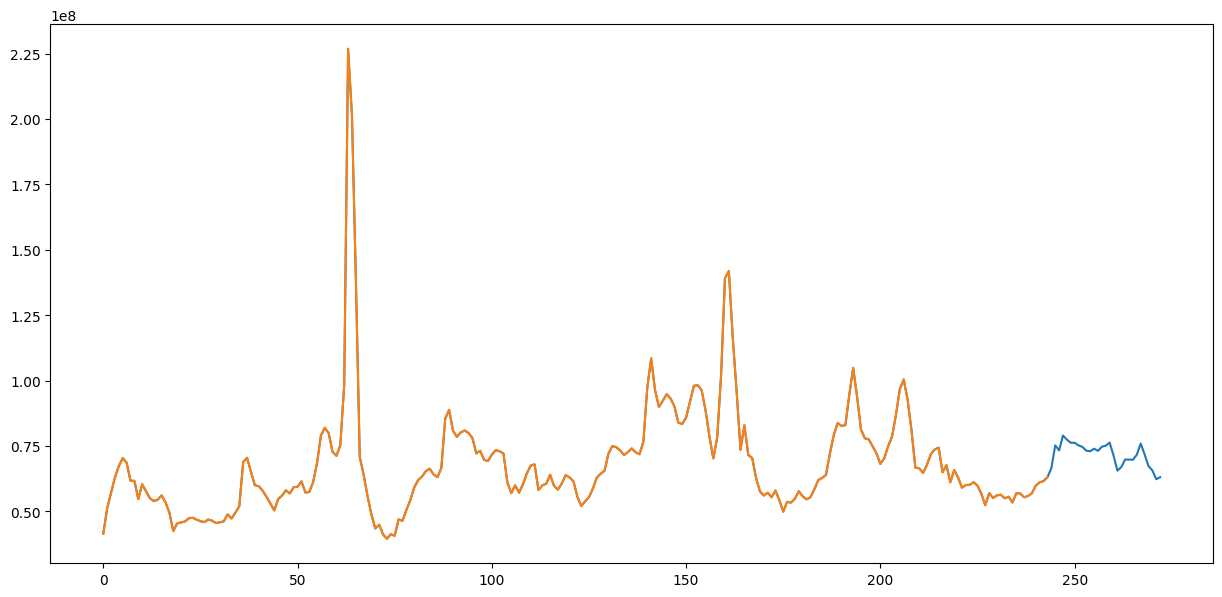

In [ ]:
plt.figure(figsize=(15, 7))

plt.plot(prev + preds)
plt.plot(prev)

In [ ]:
prev

[41535567.338999964,
 51222286.227000006,
 57127348.90799998,
 63040990.93950002,
 67336888.86750002,
 70424479.9545,
 68621184.93300007,
 61742982.70350003,
 61669241.686500005,
 54711731.21400006,
 60370834.18800002,
 57711047.93999998,
 54984651.26700004,
 53957100.97050005,
 54465673.57350004,
 56102193.06300003,
 53522514.769499965,
 49595583.16650007,
 42497605.752000004,
 45385737.547499985,
 45787518.13649999,
 46130274.30899997,
 47373923.06849999,
 47580378.55199999,
 46851319.504499994,
 46248933.51749998,
 45910321.065,
 46879679.70000002,
 46447160.056499965,
 45545038.99050008,
 45828373.647000015,
 46180807.48050001,
 48863738.112000026,
 47269759.00499999,
 49555107.10500006,
 51982737.99600003,
 68873074.65150003,
 70505388.77550001,
 65132318.19150002,
 60006025.81050006,
 59637796.270500004,
 57930762.3615,
 55576825.00649996,
 52992172.274999976,
 50367878.20049999,
 54698274.22499996,
 56055933.38099999,
 58039938.02249994,
 56847955.961999975,
 59259533.47649997,
